In [2]:
import torch
import torchvision
import os
import numpy as np
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import cv2
import copy

In [3]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [4]:
# split dataset
posA = "dataset/celeA"
posB = "dataset/flickr"
negA = "dataset/stylegan"
negB = "dataset/fake1000/"

In [5]:
traindata = [os.path.join(posA,filename)for filename in os.listdir(posA)][:800] + \
            [os.path.join(posB,filename)for filename in os.listdir(posB)][:800] + \
            [os.path.join(negA,filename)for filename in os.listdir(negA)][:800] + \
            [os.path.join(negB,filename)for filename in os.listdir(negB)][:800]
trainlabel = [1]*1600 + [0]*1600

validdata = [os.path.join(posA,filename)for filename in os.listdir(posA)][800:900] + \
            [os.path.join(posB,filename)for filename in os.listdir(posB)][800:900] + \
            [os.path.join(negA,filename)for filename in os.listdir(negA)][800:900] + \
            [os.path.join(negB,filename)for filename in os.listdir(negB)][800:900]
validlabel = [1]*200 + [0]*200

testdata  = [os.path.join(posA,filename)for filename in os.listdir(posA)][900:] + \
            [os.path.join(posB,filename)for filename in os.listdir(posB)][900:] + \
            [os.path.join(negA,filename)for filename in os.listdir(negA)][900:] + \
            [os.path.join(negB,filename)for filename in os.listdir(negB)][900:]
testlabel = [1]*200 + [0]*200

len(traindata),len(validdata),len(testdata),len(trainlabel),len(validlabel),len(testlabel)

(3200, 400, 400, 3200, 400, 400)

In [6]:
def SRMConv(img):
    filter1 = np.array([[0,0,0,0,0],
                        [0,-1,2,-1,0],
                        [0,2,-4,2,0],
                        [0,-1,2,-1,0],
                        [0,0,0,0,0]]) /4
    filter2 = np.array([[-1,2,-2,2,-1],
                        [2,-6,8,-6,2],
                        [-2,8,-12,8,-2],
                        [2,-6,8,-6,2],
                        [-1,2,-2,2,-1]]) / 12
    filter3 = np.array([[0,0,0,0,0],
                        [0,0,0,0,0],
                        [0,1,-2,1,0],
                        [0,0,0,0,0],
                        [0,0,0,0,0]]) / 2
    dst1 = np.sum(cv2.filter2D(img, cv2.CV_32F, filter1),axis=2)
    dst2 = np.sum(cv2.filter2D(img, cv2.CV_32F, filter2),axis=2)
    dst3 = np.sum(cv2.filter2D(img, cv2.CV_32F, filter3),axis=2)
    
    #noise = np.concatenate((dst1,dst2,dst3),axis=2)
    noise = np.dstack((dst1,dst2,dst3))
    return noise

In [7]:
class DeepfakeData(Dataset):
    def __init__(self, pathList, labelList, transform=None):
        self.pathList = pathList
        self.labelList = labelList
        self.transform = transform

    def __len__(self):
        return len(self.pathList)
    
    def __getitem__(self,index):
        
        img = cv2.imread(self.pathList[index])
        img = SRMConv(img)
        label = self.labelList[index]
        
        if self.transform:
            img = self.transform(img)
            
        return img, label


In [8]:
transform = transforms.Compose([transforms.ToTensor()])
traindataset = DeepfakeData(traindata, trainlabel, transform)
validdataset = DeepfakeData(validdata, validlabel, transform)
testdataset = DeepfakeData(testdata, testlabel, transform)

In [9]:
batchsize = 4
trainloader = DataLoader(traindataset, batch_size=batchsize, shuffle=True, num_workers=4)
validloader = DataLoader(validdataset)
testloader = DataLoader(testdataset)

### train

In [14]:
net = torchvision.models.resnet18(pretrained=True)
net.fc = torch.nn.Linear(in_features=512, out_features=2, bias=True)
net.cuda()
epoch_max = 50
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [15]:
acc_max = 0
for epoch in range(epoch_max):
    loss_epoch = 0
    loss_count = 0
    net.train()
    for i, (img,label) in enumerate(trainloader):
        img = img.cuda()
        label = torch.tensor(label,dtype=torch.int64).cuda()

        optimizer.zero_grad()
        output = net(img)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        
        loss_epoch += loss
        loss_count += 1
        
        if i*batchsize%400 == 0:
            print("Epoch:{} Loss:{} iter:{}".format(epoch, loss_epoch/loss_count, i*batchsize))
            loss_epoch = 0
            loss_count = 0
            
    
            
    loss_epoch = 0
    loss_count = 0
    predict = []
    expect = []
    net.eval()
    for i, (img,label) in enumerate(validloader):
        img = img.cuda()
        label = torch.tensor(label,dtype=torch.int64).cuda()
        with torch.no_grad():
            output = net(img)
        loss = criterion(output, label)
        
        loss_epoch += loss
        loss_count += 1
        
        predict.append(np.argmax(output.cpu().numpy()))
        expect.append(label.cpu().numpy().item())
    acc = accuracy_score(expect, predict)
    pre = precision_score(expect, predict)
    rec = recall_score(expect, predict)
    
    if acc_max < acc:
        print("!")
        acc_max = acc
        best_model_wts = copy.deepcopy(net.state_dict())
        best_epoch = epoch
    
    print("EVALUATION\nEpoch:{} Loss:{} acc:{} precision:{} recall:{}".format(epoch, loss_epoch/loss_count, acc, pre, rec))
    print("##########################################################################")

/data/home/wws/environment/python3.5.2/local/lib/python3.5/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Epoch:0 Loss:0.5473988056182861 iter:0
Epoch:0 Loss:0.5571123957633972 iter:400
Epoch:0 Loss:0.5048344731330872 iter:800
Epoch:0 Loss:0.27719104290008545 iter:1200
Epoch:0 Loss:0.40778082609176636 iter:1600
Epoch:0 Loss:0.40669921040534973 iter:2000
Epoch:0 Loss:0.3124200105667114 iter:2400
Epoch:0 Loss:0.39247533679008484 iter:2800


/data/home/wws/environment/python3.5.2/local/lib/python3.5/site-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


!
EVALUATION
Epoch:0 Loss:0.2858770489692688 acc:0.875 precision:0.8 recall:1.0
##########################################################################
Epoch:1 Loss:0.4075040817260742 iter:0
Epoch:1 Loss:0.2571195065975189 iter:400
Epoch:1 Loss:0.49103817343711853 iter:800
Epoch:1 Loss:0.252848356962204 iter:1200
Epoch:1 Loss:0.42270052433013916 iter:1600
Epoch:1 Loss:0.3584114611148834 iter:2000
Epoch:1 Loss:0.4536975026130676 iter:2400
Epoch:1 Loss:0.25435951352119446 iter:2800
EVALUATION
Epoch:1 Loss:0.26875773072242737 acc:0.86 precision:0.78125 recall:1.0
##########################################################################
Epoch:2 Loss:0.0005568265914916992 iter:0
Epoch:2 Loss:0.28068438172340393 iter:400
Epoch:2 Loss:0.2597363293170929 iter:800
Epoch:2 Loss:0.23399774730205536 iter:1200
Epoch:2 Loss:0.21877151727676392 iter:1600
Epoch:2 Loss:0.2744918167591095 iter:2000
Epoch:2 Loss:0.233967587351799 iter:2400
Epoch:2 Loss:0.22861191630363464 iter:2800
!
EVALUATION
Epoch

EVALUATION
Epoch:16 Loss:0.02577458880841732 acc:0.9825 precision:0.9753694581280788 recall:0.99
##########################################################################
Epoch:17 Loss:0.00022900104522705078 iter:0
Epoch:17 Loss:0.010812466964125633 iter:400
Epoch:17 Loss:0.015947017818689346 iter:800
Epoch:17 Loss:0.024797329679131508 iter:1200
Epoch:17 Loss:0.038854777812957764 iter:1600
Epoch:17 Loss:0.015768393874168396 iter:2000
Epoch:17 Loss:0.0022995828185230494 iter:2400
Epoch:17 Loss:0.005000703036785126 iter:2800
EVALUATION
Epoch:17 Loss:0.03818516805768013 acc:0.985 precision:0.970873786407767 recall:1.0
##########################################################################
Epoch:18 Loss:0.0011220574378967285 iter:0
Epoch:18 Loss:0.008190037682652473 iter:400
Epoch:18 Loss:0.009465810842812061 iter:800
Epoch:18 Loss:0.006425253581255674 iter:1200
Epoch:18 Loss:0.03478994593024254 iter:1600
Epoch:18 Loss:0.013434638269245625 iter:2000
Epoch:18 Loss:0.015996430069208145 i

Epoch:34 Loss:0.0002781939401756972 iter:1200
Epoch:34 Loss:0.0010206981096416712 iter:1600
Epoch:34 Loss:0.0012120744213461876 iter:2000
Epoch:34 Loss:0.0001202458151965402 iter:2400
Epoch:34 Loss:0.0008610254153609276 iter:2800
EVALUATION
Epoch:34 Loss:0.02584710717201233 acc:0.99 precision:0.9803921568627451 recall:1.0
##########################################################################
Epoch:35 Loss:1.6689300537109375e-06 iter:0
Epoch:35 Loss:0.017591873183846474 iter:400
Epoch:35 Loss:0.00215041427873075 iter:800
Epoch:35 Loss:0.0048070913180708885 iter:1200
Epoch:35 Loss:0.0038072913885116577 iter:1600
Epoch:35 Loss:0.0010765758343040943 iter:2000
Epoch:35 Loss:0.001217132667079568 iter:2400
Epoch:35 Loss:0.0012566337827593088 iter:2800
EVALUATION
Epoch:35 Loss:0.01956123299896717 acc:0.99 precision:0.9803921568627451 recall:1.0
##########################################################################
Epoch:36 Loss:6.985664367675781e-05 iter:0
Epoch:36 Loss:0.0007047217804

KeyboardInterrupt: 

In [16]:
torch.save(best_model_wts,"Noise_Epoch{}_validAcc{}".format(best_epoch,acc_max))

In [ ]:
net.load_state_dict(best_model_wts)

In [ ]:
epoch_max = 50
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)

In [ ]:
acc_max = 0
for epoch in range(epoch_max):
    loss_epoch = 0
    loss_count = 0
    net.train()
    for i, (img,label) in enumerate(trainloader):
        img = img.cuda()
        label = torch.tensor(label,dtype=torch.int64).cuda()

        optimizer.zero_grad()
        output = net(img)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        
        loss_epoch += loss
        loss_count += 1
        
        if i*batchsize%400 == 0:
            print("Epoch:{} Loss:{} iter:{}".format(epoch, loss_epoch/loss_count, i*batchsize))
            loss_epoch = 0
            loss_count = 0
            
    
            
    loss_epoch = 0
    loss_count = 0
    predict = []
    expect = []
    net.eval()
    for i, (img,label) in enumerate(validloader):
        img = img.cuda()
        label = torch.tensor(label,dtype=torch.int64).cuda()
        with torch.no_grad():
            output = net(img)
        loss = criterion(output, label)
        
        loss_epoch += loss
        loss_count += 1
        
        predict.append(np.argmax(output.cpu().numpy()))
        expect.append(label.cpu().numpy().item())
    acc = accuracy_score(expect, predict)
    pre = precision_score(expect, predict)
    rec = recall_score(expect, predict)
    
    if acc_max < acc:
        print("!")
        acc_max = acc
        best_model_wts = copy.deepcopy(net.state_dict())
        best_epoch = epoch
    
    print("EVALUATION\nEpoch:{} Loss:{} acc:{} precision:{} recall:{}".format(epoch, loss_epoch/loss_count, acc, pre, rec))
    print("##########################################################################")

In [ ]:
torch.save(best_model_wts,"Noise_Finetuning_Epoch{}_validAcc{}".format(best_epoch,acc_max))

### Visualization

In [10]:
import resnet_cam
import cam_noise as cam
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
net = resnet_cam.resnet18(pretrained=False)
net.fc = torch.nn.Linear(in_features=512, out_features=2, bias=True)

In [12]:
net.load_state_dict(torch.load("Noise_Epoch29_validAcc1.0"))
net.cuda()
_ = net.eval()

In [13]:
cam_drawer = cam.Drawer(net)

(2, 512, 1, 1)


In [14]:
predict = []
expect = []
for i in range(len(testdata)):
    imgPath = testdata[i]
    imgLabel = testlabel[i]
    pre_cls, raw_img, heatmap, _ = cam_drawer.get_heat_map(testdata[i],camtype=0)
    expect.append(imgLabel)
    predict.append(pre_cls)

In [15]:
acc = accuracy_score(expect, predict)
pre = precision_score(expect, predict)
rec = recall_score(expect, predict)
print("EVALUATION acc:{} precision:{} recall:{}".format(acc, pre, rec))

EVALUATION acc:1.0 precision:1.0 recall:1.0


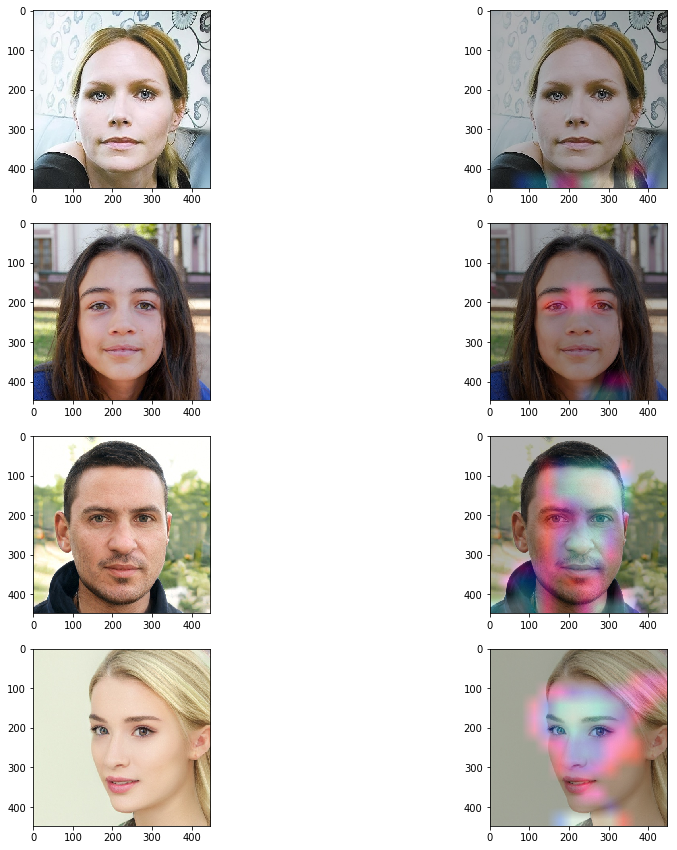

In [16]:
plt.figure(figsize=(15,15))

plt.subplot(421)
plt.imshow(cam_drawer.get_heat_map(testdata[1],camtype=0)[1])
plt.subplot(422)
plt.imshow(cam_drawer.get_heat_map(testdata[1],camtype=0)[2])

plt.subplot(423)
plt.imshow(cam_drawer.get_heat_map(testdata[101],camtype=0)[1])
plt.subplot(424)
plt.imshow(cam_drawer.get_heat_map(testdata[101],camtype=0)[2])

plt.subplot(425)
plt.imshow(cam_drawer.get_heat_map(testdata[201],camtype=0)[1])
plt.subplot(426)
plt.imshow(cam_drawer.get_heat_map(testdata[201],camtype=0)[2])

plt.subplot(427)
plt.imshow(cam_drawer.get_heat_map(testdata[301],camtype=0)[1])
plt.subplot(428)
plt.imshow(cam_drawer.get_heat_map(testdata[301],camtype=0)[2])

plt.show()

In [19]:
predict = []
expect = []
errorImg = []
errorCAM = []
errorGT = []
for i in range(len(validdata)):
    imgPath = validdata[i]
    imgLabel = validlabel[i]
    pre_cls, raw_img, heatmap, _ = cam_drawer.get_heat_map(validdata[i],camtype=0)
    expect.append(imgLabel)
    predict.append(pre_cls)
    
    if i in [204,246]:
        errorImg.append(raw_img)
        errorCAM.append(heatmap)
        errorGT.append(imgLabel)

In [20]:
acc = accuracy_score(expect, predict)
pre = precision_score(expect, predict)
rec = recall_score(expect, predict)
print("EVALUATION acc:{} precision:{} recall:{}".format(acc, pre, rec))

EVALUATION acc:1.0 precision:1.0 recall:1.0


两张合成图像被判定为真实图像


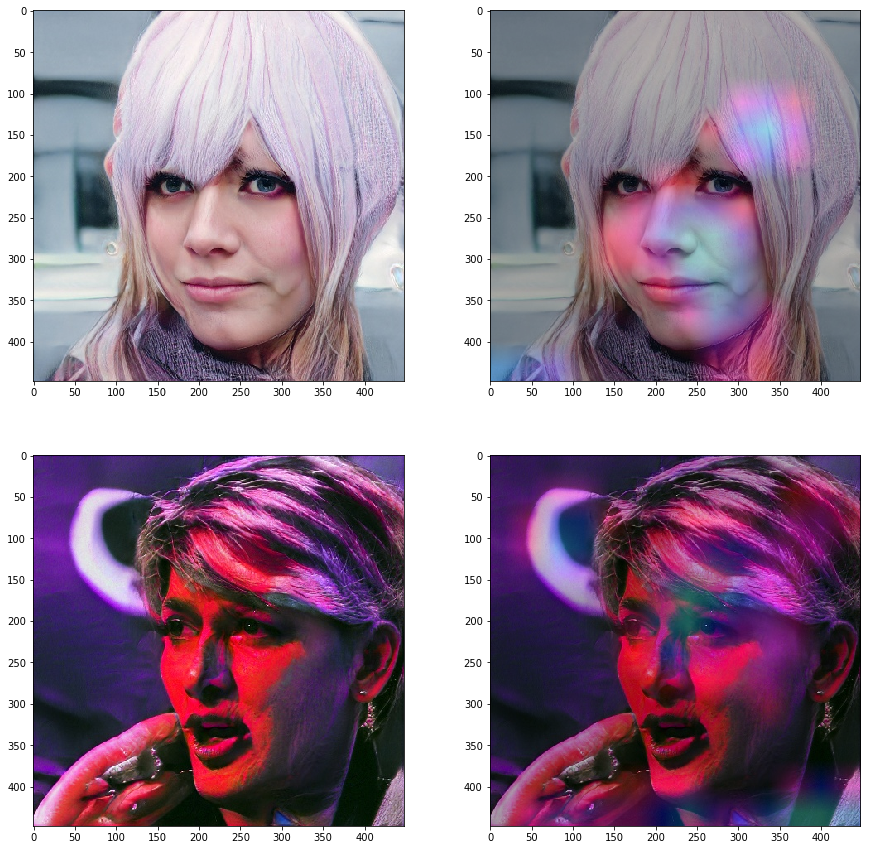

In [21]:
plt.figure(figsize=(15,15))
print("两张合成图像被判定为真实图像")

#print(errorGT[0])
plt.subplot(221)
plt.imshow(errorImg[0])
plt.subplot(222)
plt.imshow(errorCAM[0])

#print(errorGT[1])
plt.subplot(223)
plt.imshow(errorImg[1])
plt.subplot(224)
plt.imshow(errorCAM[1])

plt.show()

两张合成图像被判定为真实图像


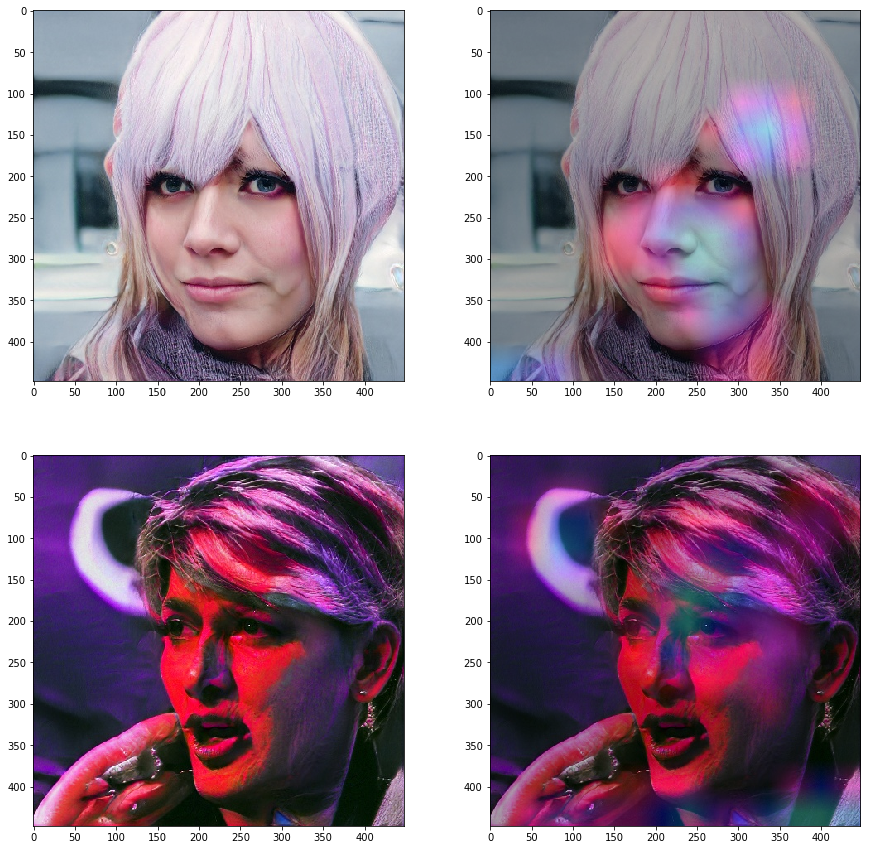

In [22]:
plt.figure(figsize=(15,15))
print("两张合成图像被判定为真实图像")

#print(errorGT[0])
plt.subplot(221)
plt.imshow(errorImg[0])
plt.subplot(222)
plt.imshow(errorCAM[0])

#print(errorGT[1])
plt.subplot(223)
plt.imshow(errorImg[1])
plt.subplot(224)
plt.imshow(errorCAM[1])

plt.show()